In [1]:
!pip install -q --upgrade wandb
!pip install -q ttach
!pip install  timm

     |████████████████████████████████| 431 kB 277 kB/s            


# Data loading

In [2]:
import os

SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = './turtle_recall/images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
    %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
    %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
    %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


In [3]:
import pandas as pd
import requests
import io
import urllib.parse

BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
    url = urllib.parse.urljoin(BASE_URL, file_name)
    content = requests.get(url).content
    return pd.read_csv(io.StringIO(content.decode('utf-8')))


# Read in csv files.
extra = read_csv_from_web("extra_images.csv")
extra["type"] = "extra"
train = read_csv_from_web('train.csv')
train["type"] = "train"
test = read_csv_from_web('test.csv')
sample_submission = read_csv_from_web('sample_submission.csv')

# Convert image_location strings to lowercase.
for df in [train, test]:
    df.image_location = df.image_location.apply(lambda x: x.lower())
    assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

In [4]:
def get_image_paths(image_id):
    return f"./turtle_recall/images/{image_id}.JPG"

#train = pd.concat([train, extra])
#train = train.reset_index(drop=True)
train['directory'] = train["image_id"].map(get_image_paths)
#train.loc[(train.type == 'extra'),'turtle_id']='new_turtle'

In [5]:
train.head()

,image_id,image_location,turtle_id,type,directory
0,ID_2RK4WLN8,top,t_id_VP2NW7aV,train,./turtle_recall/images/ID_2RK4WLN8.JPG
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC,train,./turtle_recall/images/ID_VVW0QXLX.JPG
2,ID_RVATH2HZ,right,t_id_3b65X5Lw,train,./turtle_recall/images/ID_RVATH2HZ.JPG
3,ID_2GB90GPS,left,t_id_YjXYTCGC,train,./turtle_recall/images/ID_2GB90GPS.JPG
4,ID_LM6S0B1M,top,t_id_d6aYXtor,train,./turtle_recall/images/ID_LM6S0B1M.JPG


In [6]:
train["turtle_id"].value_counts().sort_values()

t_id_J5dngbNA     8
t_id_OqU1NWEA     9
t_id_p77GDtzg     9
t_id_Dv4O8bOM    10
t_id_Lhp87PBX    10
                 ..
t_id_dVQ4x3wz    47
t_id_Kf73l69A    57
t_id_VP2NW7aV    58
t_id_hRzOoJ2t    68
t_id_ROFhVsy2    77
Name: turtle_id, Length: 100, dtype: int64

# Directory settings

In [7]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Label encoder

In [8]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train['turtle_id'])
train['turtle_id_enc'] = le.transform(train['turtle_id'])
pd.to_pickle(le, "./label_encoder.pkl")

# Configuration

In [9]:
class CFG:
    apex=False
    debug=False
    print_freq=100
    size=150
    num_workers=8
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    epochs=20
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':4,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':2,
        'eta_min':1e-5,
        'T_mult':1,
        'last_epoch':-1
    }
    onecycle_params={
        'pct_start':0.1,
        'div_factor':1e2,
        'max_lr':1e-3
    }
    batch_size=128
    lr=1e-3
    weight_decay=1e-5
    gradient_accumulation_steps=1
    max_grad_norm=1000
    target_size=train["turtle_id_enc"].shape[0]
    nfolds=5
    trn_folds=[0, 1, 2, 3, 4]
    model_name='resnet50d'     #'vit_base_patch32_224_in21k' 'tf_efficientnetv2_b0' 'resnext50_32x4d'
    train=True
    preds_score_labels=["top1_score", "top2_score", "top3_score", "top4_score", "top5_score"]
    preds_loss_labels=["top1_loss", "top2_loss", "top3_loss", "top4_loss", "top5_loss"]
    early_stop=True
    target_col="turtle_id_enc"
    margin=50
    scale=0.3
    fc_dim=512
    early_stopping_steps=5
    grad_cam=False
    seed=42
    
if CFG.debug:
    CFG.epochs=1
    train=train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import sys
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image
from PIL import ImageFile
# sometimes, you will have images without an ending bit
# this takes care of those kind of (corrupt) images
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.optimizer import Optimizer
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau


import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform


import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# W&B

In [11]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_key")

import wandb
wandb.login(key=wandb_api)

def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

run = wandb.init(project="Herbarium 2022", 
                 name="resnext50_32x4d",
                 config=class2dict(CFG),
                 group=CFG.model_name,
                 job_type="train")

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: djoe (use `wandb login --relogin` to force relogin)


# Utils

In [12]:
# ====================================================
# Utils
# ====================================================
#def apk(actual, predicted):
#     """Computes the average precision at k.
#
#     Args:
#     actual: The turtle ID to be predicted.
#     predicted : A list of predicted turtle IDs (order does matter).
#     k : The maximum number of predicted elements.
#
#    Returns:
#      The average precision at k.
#    """
#    score = 0.0
#    num_hits = 0.0
#
#    for i, p in enumerate(predicted):
#        if p == actual and p not in predicted[:i]:
#            num_hits += 1.0
#            score += num_hits / (i + 1.0)
#
#    return score
#
#
#def mapk(actual, predicted):
#  """ Computes the mean average precision at k.
#
#    The turtle ID at actual[i] will be used to score predicted[i][:k] so order
#    matters throughout!
#
#    actual: A list of the true turtle IDs to score against.
#    predicted: A list of lists of predicted turtle IDs.
#    k: The size of the window to score within.
#
#    Returns:
#      The mean average precision at k.
#  """
#  return np.mean([apk(a, p) for a, p in zip(actual, predicted)])

def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

# CV schem

In [13]:
%%time
skf = StratifiedKFold(n_splits=CFG.nfolds, shuffle=True, random_state=CFG.seed)
for fold, (trn_idx, vld_idx) in enumerate(skf.split(train, train[CFG.target_col])):
    train.loc[vld_idx, "folds"] = int(fold)
train["folds"] = train["folds"].astype(int)

CPU times: user 9 ms, sys: 759 µs, total: 9.76 ms
Wall time: 13.1 ms


# Dataset

In [14]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df['directory'].values
        self.labels = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        try:
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            image = Image.open(file_path)
            image = image.convert("RGB")
            image = np.array(image)
        if self.transform:
            image = self.transform(image=image)['image']
        label = torch.tensor(self.labels[idx]).float()
        return image, label


In [15]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose(
        [
           A.Resize(CFG.size, CFG.size),
           A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            A.Flip(p=0.05),
            
            A.Cutout(p=0.05),
            A.HorizontalFlip(p=0.05),
            A.VerticalFlip(p=0.05),
            A.Rotate(limit=180, p=0.05),
            A.ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.05
            ),
            A.HueSaturationValue(
                hue_shift_limit=0.2, sat_shift_limit=0.4,
                val_shift_limit=0.2, p=0.05
            ),
            A.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.1, 0.1), p=0.05
            ),
            ToTensorV2(p=1.0),
        ]
    )

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

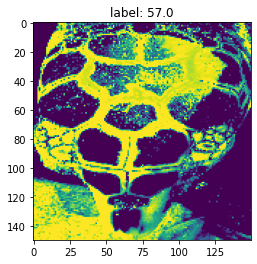

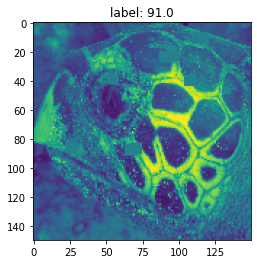

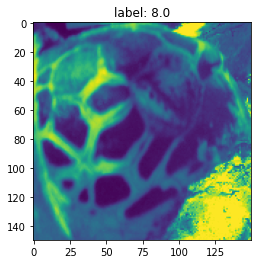

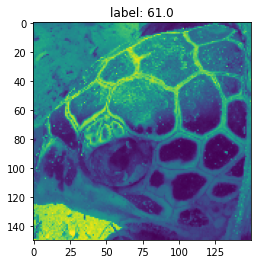

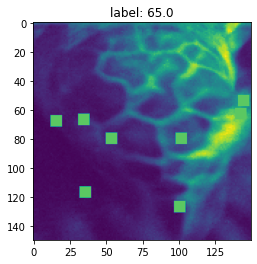

In [16]:
train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    plt.figure(figsize=(4, 4))
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

# models

In [17]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output

In [18]:
# ====================================================
# MODEL
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained, in_chans=3)
        
        if cfg.model_name == 'tf_efficientnetv2_b0':
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(self.n_features, self.cfg.fc_dim)
        
        #if cfg.model_name.split('_')[1] == "efficientnet":
        #    self.n_features = self.model.classifier.in_features
        #    self.model.classifier = nn.Linear(self.n_features, self.cfg.fc_dim)
            
        if "resne" in cfg.model_name:
            self.in_features = self.model.fc.in_features
            self.model.fc = nn.Linear(self.in_features, self.cfg.fc_dim)
            
        elif cfg.model_name.split('_')[0] == 'vit':
            self.n_features = self.model.head.in_features
            self.model.head = nn.Linear(self.n_features, self.cfg.fc_dim)
        
        self.fc = nn.Linear(self.cfg.fc_dim, self.cfg.target_size)

    def forward(self, x):
        features = self.model(x)
        output = self.fc(features)
        return output

In [19]:
class turtleModel(nn.Module):

    def __init__(
        self,
        n_classes = CFG.target_size,
        model_name = CFG.model_name,
        fc_dim = CFG.fc_dim,
        margin = CFG.margin,
        scale = CFG.scale,
        use_fc = True,
        use_arcface = True,
        pretrained = True):


        super(turtleModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.model = timm.create_model(model_name, pretrained=pretrained)
        
        if "resne" in CFG.model_name:
            self.in_features = self.model.fc.in_features
            self.model.fc = nn.Identity()
            self.model.global_pool = nn.Identity()
            

        elif 'efficientnet' in model_name:
            self.in_features = self.model.classifier.in_features
            self.model.classifier = nn.Identity()
            self.model.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            self.in_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Identity()
            self.model.head.global_pool = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc
        self.use_arcface = use_arcface

        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(self.in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.arcface = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image, label):
        feature = self.extract_feat(image)
        
        if self.use_arcface:
            logits = self.arcface(feature, label)
            
        return logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.model(x)
        x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

# Helper function

In [20]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.apex:
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device).float()
        labels = labels.to(device).long()
        batch_size = labels.size(0)
        if CFG.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds, labels)
        else:
            y_preds = model(images, labels)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            if CFG.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f} '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        wandb.log({f"[fold{fold}] loss": losses.val,
                   f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    
    activation = nn.Softmax(dim=1)
    all_predicts, all_confs = [], []
    
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device).float()
        labels = labels.to(device).long()
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images, labels)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        y_preds = activation(y_preds)
        confs, predicts = torch.topk(y_preds, 5)
        all_predicts.append(predicts.to('cpu').numpy())
        #all_confs.append(confs.to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(all_predicts)
    return losses.avg, predictions

# Train Loop

In [21]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['folds'] != fold].index
    val_idx = folds[folds['folds'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds["turtle_id"].values

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = turtleModel(pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()
    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        
        #preds_label = np.argmax(preds, axis=1)
        #score = mapk(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        #LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        wandb.log({f"[fold{fold}] epoch": epoch+1, 
                   f"[fold{fold}] avg_train_loss": avg_loss, 
                   f"[fold{fold}] avg_val_loss": avg_val_loss})
                   #f"[fold{fold}] score": score})

        #if score >= best_score:
        #    best_score = score
        #    LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        #    torch.save({'model': model.state_dict(), 
        #                'preds_score': preds},
        #                OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds_loss': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
        
        
    #valid_folds[CFG.preds_score_labels] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth', 
    #                                  map_location=torch.device('cpu'))['preds_score']
    valid_folds[CFG.preds_loss_labels] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth', 
                                      map_location=torch.device('cpu'))['preds_loss']
   

    return valid_folds

In [22]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train 
    """

    def get_result(result_df):
        preds_score = result_df[CFG.preds_score_labels].values
        preds_loss = result_df[CFG.preds_loss_labels].values
        labels = result_df["turtle_id"].values
        #score = mapk(labels, preds_score)
        #score_loss = mapk(labels, preds_loss)
        #LOGGER.info(f'Score with best score weights: {score:<.4f}')
        #LOGGER.info(f'Score with best loss weights: {score_loss:<.4f}')
    
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.nfolds):
            if fold in CFG.trn_folds:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                #get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        #get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
        
    wandb.finish()

In [23]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Building Model Backbone for resnet50d model


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to /root/.cache/torch/hub/checkpoints/resnet50d_ra2-464e36ba.pth


Epoch: [1][0/13] Elapsed 0m 35s (remain 7m 0s) Loss: 7.5922(7.5922) Grad: 0.1527 LR: 0.001000  
Epoch: [1][12/13] Elapsed 0m 42s (remain 0m 0s) Loss: 7.5717(7.5819) Grad: 0.1525 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.6350(7.6350) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.6360(7.6354) 


Epoch 1 - avg_train_loss: 7.5819  avg_val_loss: 7.6354  time: 53s
Epoch 1 - Save Best Loss: 7.6354 Model


Epoch: [2][0/13] Elapsed 0m 25s (remain 5m 4s) Loss: 7.5327(7.5327) Grad: 0.1339 LR: 0.000505  
Epoch: [2][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.4574(7.5021) Grad: 0.1083 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.4772(7.4772) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.4926(7.4834) 


Epoch 2 - avg_train_loss: 7.5021  avg_val_loss: 7.4834  time: 51s
Epoch 2 - Save Best Loss: 7.4834 Model


Epoch: [3][0/13] Elapsed 0m 22s (remain 4m 25s) Loss: 7.4345(7.4345) Grad: 0.1268 LR: 0.001000  
Epoch: [3][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.2918(7.3585) Grad: 0.0767 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2752(7.2752) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.2840(7.2788) 


Epoch 3 - avg_train_loss: 7.3585  avg_val_loss: 7.2788  time: 50s
Epoch 3 - Save Best Loss: 7.2788 Model


Epoch: [4][0/13] Elapsed 0m 22s (remain 4m 27s) Loss: 7.2719(7.2719) Grad: 0.0569 LR: 0.000505  
Epoch: [4][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.2211(7.2473) Grad: 0.0440 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2235(7.2235) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.2320(7.2269) 


Epoch 4 - avg_train_loss: 7.2473  avg_val_loss: 7.2269  time: 50s
Epoch 4 - Save Best Loss: 7.2269 Model


Epoch: [5][0/13] Elapsed 0m 24s (remain 4m 48s) Loss: 7.2173(7.2173) Grad: 0.0446 LR: 0.001000  
Epoch: [5][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1663(7.1904) Grad: 0.0310 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1686(7.1686) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1758(7.1715) 


Epoch 5 - avg_train_loss: 7.1904  avg_val_loss: 7.1715  time: 50s
Epoch 5 - Save Best Loss: 7.1715 Model


Epoch: [6][0/13] Elapsed 0m 24s (remain 4m 49s) Loss: 7.1760(7.1760) Grad: 0.0308 LR: 0.000505  
Epoch: [6][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1530(7.1682) Grad: 0.0699 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1616(7.1616) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1704(7.1652) 


Epoch 6 - avg_train_loss: 7.1682  avg_val_loss: 7.1652  time: 49s
Epoch 6 - Save Best Loss: 7.1652 Model


Epoch: [7][0/13] Elapsed 0m 20s (remain 4m 4s) Loss: 7.1523(7.1523) Grad: 0.0405 LR: 0.001000  
Epoch: [7][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1547(7.1458) Grad: 0.0498 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1647(7.1647) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1920(7.1757) 


Epoch 7 - avg_train_loss: 7.1458  avg_val_loss: 7.1757  time: 49s


Epoch: [8][0/13] Elapsed 0m 26s (remain 5m 12s) Loss: 7.1462(7.1462) Grad: 0.0344 LR: 0.000505  
Epoch: [8][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1563(7.1794) Grad: 0.0597 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1345(7.1345) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1368(7.1354) 


Epoch 8 - avg_train_loss: 7.1794  avg_val_loss: 7.1354  time: 49s
Epoch 8 - Save Best Loss: 7.1354 Model


Epoch: [9][0/13] Elapsed 0m 22s (remain 4m 29s) Loss: 7.1705(7.1705) Grad: 4.0103 LR: 0.001000  
Epoch: [9][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1517(7.1485) Grad: 0.5298 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2180(7.2180) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1827(7.2038) 


Epoch 9 - avg_train_loss: 7.1485  avg_val_loss: 7.2038  time: 49s


Epoch: [10][0/13] Elapsed 0m 23s (remain 4m 40s) Loss: 7.1499(7.1499) Grad: 0.0245 LR: 0.000505  
Epoch: [10][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1664(7.1390) Grad: 0.0226 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.6283(7.6283) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.5608(7.6011) 


Epoch 10 - avg_train_loss: 7.1390  avg_val_loss: 7.6011  time: 49s


Epoch: [11][0/13] Elapsed 0m 20s (remain 4m 8s) Loss: 7.1625(7.1625) Grad: 0.3276 LR: 0.001000  
Epoch: [11][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1249(7.1482) Grad: 0.8225 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1129(7.1129) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1146(7.1136) 


Epoch 11 - avg_train_loss: 7.1482  avg_val_loss: 7.1136  time: 50s
Epoch 11 - Save Best Loss: 7.1136 Model


Epoch: [12][0/13] Elapsed 0m 21s (remain 4m 20s) Loss: 7.1209(7.1209) Grad: 0.0244 LR: 0.000505  
Epoch: [12][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.1203(7.1284) Grad: 0.0755 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1223(7.1223) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1115(7.1179) 


Epoch 12 - avg_train_loss: 7.1284  avg_val_loss: 7.1179  time: 50s


Epoch: [13][0/13] Elapsed 0m 23s (remain 4m 37s) Loss: 7.1203(7.1203) Grad: 0.0097 LR: 0.001000  
Epoch: [13][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1341(7.1266) Grad: 0.0588 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1279(7.1279) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1130(7.1219) 


Epoch 13 - avg_train_loss: 7.1266  avg_val_loss: 7.1219  time: 49s


Epoch: [14][0/13] Elapsed 0m 24s (remain 4m 59s) Loss: 7.1260(7.1260) Grad: 0.0499 LR: 0.000505  
Epoch: [14][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1342(7.1223) Grad: 0.0477 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2209(7.2209) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.2581(7.2359) 


Epoch 14 - avg_train_loss: 7.1223  avg_val_loss: 7.2359  time: 49s


Epoch: [15][0/13] Elapsed 0m 21s (remain 4m 17s) Loss: 7.1170(7.1170) Grad: 0.0059 LR: 0.001000  
Epoch: [15][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1168(7.1215) Grad: 0.0054 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1779(7.1779) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1955(7.1850) 


Epoch 15 - avg_train_loss: 7.1215  avg_val_loss: 7.1850  time: 48s


Epoch: [16][0/13] Elapsed 0m 23s (remain 4m 37s) Loss: 7.1248(7.1248) Grad: 0.1933 LR: 0.000505  
Epoch: [16][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1249(7.1198) Grad: 0.0179 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1314(7.1314) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1647(7.1448) 


Epoch 16 - avg_train_loss: 7.1198  avg_val_loss: 7.1448  time: 49s


Epoch: [17][0/13] Elapsed 0m 24s (remain 4m 53s) Loss: 7.1336(7.1336) Grad: 0.0489 LR: 0.001000  
Epoch: [17][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1236(7.1219) Grad: 0.3772 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1273(7.1273) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1277(7.1275) 


Epoch 17 - avg_train_loss: 7.1219  avg_val_loss: 7.1275  time: 50s


Epoch: [18][0/13] Elapsed 0m 20s (remain 4m 3s) Loss: 7.1282(7.1282) Grad: 1.7160 LR: 0.000505  
Epoch: [18][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1166(7.1207) Grad: 0.0053 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1539(7.1539) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1707(7.1607) 


Epoch 18 - avg_train_loss: 7.1207  avg_val_loss: 7.1607  time: 49s


Epoch: [19][0/13] Elapsed 0m 23s (remain 4m 44s) Loss: 7.1267(7.1267) Grad: 3.0307 LR: 0.001000  
Epoch: [19][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1403(7.1278) Grad: 0.3367 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1078(7.1078) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1079(7.1078) 


Epoch 19 - avg_train_loss: 7.1278  avg_val_loss: 7.1078  time: 49s
Epoch 19 - Save Best Loss: 7.1078 Model


Epoch: [20][0/13] Elapsed 0m 20s (remain 4m 11s) Loss: 7.1207(7.1207) Grad: 5.5458 LR: 0.000505  
Epoch: [20][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1250(7.1302) Grad: 0.0048 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1077(7.1077) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1077(7.1077) 


Epoch 20 - avg_train_loss: 7.1302  avg_val_loss: 7.1077  time: 49s
Epoch 20 - Save Best Loss: 7.1077 Model
========== fold: 0 result ==========
========== fold: 1 training ==========


Building Model Backbone for resnet50d model
Epoch: [1][0/13] Elapsed 0m 21s (remain 4m 22s) Loss: 7.5917(7.5917) Grad: 0.1578 LR: 0.001000  
Epoch: [1][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.5563(7.5796) Grad: 0.1340 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.6326(7.6326) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.6394(7.6354) 


Epoch 1 - avg_train_loss: 7.5796  avg_val_loss: 7.6354  time: 50s
Epoch 1 - Save Best Loss: 7.6354 Model


Epoch: [2][0/13] Elapsed 0m 20s (remain 4m 11s) Loss: 7.5232(7.5232) Grad: 0.1193 LR: 0.000505  
Epoch: [2][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.4245(7.4765) Grad: 0.0944 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.4271(7.4271) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.4303(7.4284) 


Epoch 2 - avg_train_loss: 7.4765  avg_val_loss: 7.4284  time: 49s
Epoch 2 - Save Best Loss: 7.4284 Model


Epoch: [3][0/13] Elapsed 0m 23s (remain 4m 44s) Loss: 7.4156(7.4156) Grad: 0.0971 LR: 0.001000  
Epoch: [3][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.2711(7.3416) Grad: 0.2661 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2603(7.2603) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.2588(7.2597) 


Epoch 3 - avg_train_loss: 7.3416  avg_val_loss: 7.2597  time: 50s
Epoch 3 - Save Best Loss: 7.2597 Model


Epoch: [4][0/13] Elapsed 0m 20s (remain 4m 2s) Loss: 7.2705(7.2705) Grad: 0.0947 LR: 0.000505  
Epoch: [4][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.2256(7.2445) Grad: 0.0668 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2198(7.2198) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.2385(7.2274) 


Epoch 4 - avg_train_loss: 7.2445  avg_val_loss: 7.2274  time: 49s
Epoch 4 - Save Best Loss: 7.2274 Model


Epoch: [5][0/13] Elapsed 0m 22s (remain 4m 24s) Loss: 7.2086(7.2086) Grad: 0.0440 LR: 0.001000  
Epoch: [5][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1752(7.1916) Grad: 0.0498 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.2095(7.2095) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1898(7.2016) 


Epoch 5 - avg_train_loss: 7.1916  avg_val_loss: 7.2016  time: 50s
Epoch 5 - Save Best Loss: 7.2016 Model


Epoch: [6][0/13] Elapsed 0m 21s (remain 4m 21s) Loss: 7.1650(7.1650) Grad: 0.0435 LR: 0.000505  
Epoch: [6][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1535(7.1694) Grad: 0.0417 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.4300(7.4300) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.3808(7.4101) 


Epoch 6 - avg_train_loss: 7.1694  avg_val_loss: 7.4101  time: 49s


Epoch: [7][0/13] Elapsed 0m 21s (remain 4m 17s) Loss: 7.1736(7.1736) Grad: 0.4734 LR: 0.001000  
Epoch: [7][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1531(7.1824) Grad: 0.7755 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1264(7.1264) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1265(7.1264) 


Epoch 7 - avg_train_loss: 7.1824  avg_val_loss: 7.1264  time: 50s
Epoch 7 - Save Best Loss: 7.1264 Model


Epoch: [8][0/13] Elapsed 0m 20s (remain 4m 6s) Loss: 7.1567(7.1567) Grad: 0.3604 LR: 0.000505  
Epoch: [8][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1368(7.1433) Grad: 0.0224 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1292(7.1292) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1332(7.1308) 


Epoch 8 - avg_train_loss: 7.1433  avg_val_loss: 7.1308  time: 50s


Epoch: [9][0/13] Elapsed 0m 24s (remain 4m 55s) Loss: 7.1303(7.1303) Grad: 0.0230 LR: 0.001000  
Epoch: [9][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1237(7.1299) Grad: 0.0220 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1149(7.1149) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1147(7.1148) 


Epoch 9 - avg_train_loss: 7.1299  avg_val_loss: 7.1148  time: 50s
Epoch 9 - Save Best Loss: 7.1148 Model


Epoch: [10][0/13] Elapsed 0m 24s (remain 4m 54s) Loss: 7.1240(7.1240) Grad: 0.0143 LR: 0.000505  
Epoch: [10][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1270(7.1255) Grad: 0.0178 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1125(7.1125) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1125(7.1125) 


Epoch 10 - avg_train_loss: 7.1255  avg_val_loss: 7.1125  time: 50s
Epoch 10 - Save Best Loss: 7.1125 Model


Epoch: [11][0/13] Elapsed 0m 23s (remain 4m 43s) Loss: 7.1199(7.1199) Grad: 0.0093 LR: 0.001000  
Epoch: [11][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1368(7.1298) Grad: 0.7694 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.2496(7.2496) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.2467(7.2484) 


Epoch 11 - avg_train_loss: 7.1298  avg_val_loss: 7.2484  time: 49s


Epoch: [12][0/13] Elapsed 0m 24s (remain 4m 53s) Loss: 7.1271(7.1271) Grad: 0.1310 LR: 0.000505  
Epoch: [12][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1179(7.1246) Grad: 0.0093 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1492(7.1492) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1394(7.1453) 


Epoch 12 - avg_train_loss: 7.1246  avg_val_loss: 7.1453  time: 50s


Epoch: [13][0/13] Elapsed 0m 21s (remain 4m 20s) Loss: 7.1330(7.1330) Grad: 0.8090 LR: 0.001000  
Epoch: [13][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1178(7.1296) Grad: 0.0084 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1727(7.1727) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.2352(7.1979) 


Epoch 13 - avg_train_loss: 7.1296  avg_val_loss: 7.1979  time: 50s


Epoch: [14][0/13] Elapsed 0m 20s (remain 4m 11s) Loss: 7.1279(7.1279) Grad: 0.1839 LR: 0.000505  
Epoch: [14][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1185(7.1210) Grad: 0.1784 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1535(7.1535) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1780(7.1634) 


Epoch 14 - avg_train_loss: 7.1210  avg_val_loss: 7.1634  time: 49s


Epoch: [15][0/13] Elapsed 0m 24s (remain 4m 51s) Loss: 7.1249(7.1249) Grad: 0.0332 LR: 0.001000  
Epoch: [15][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1371(7.1260) Grad: 2.6415 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1083(7.1083) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1083(7.1083) 


Epoch 15 - avg_train_loss: 7.1260  avg_val_loss: 7.1083  time: 50s
Epoch 15 - Save Best Loss: 7.1083 Model


Epoch: [16][0/13] Elapsed 0m 20s (remain 4m 0s) Loss: 7.1178(7.1178) Grad: 0.0124 LR: 0.000505  
Epoch: [16][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1274(7.1213) Grad: 0.1991 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1084(7.1084) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1085(7.1084) 


Epoch 16 - avg_train_loss: 7.1213  avg_val_loss: 7.1084  time: 49s


Epoch: [17][0/13] Elapsed 0m 23s (remain 4m 43s) Loss: 7.1257(7.1257) Grad: 0.1662 LR: 0.001000  
Epoch: [17][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1165(7.1214) Grad: 0.0056 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1079(7.1079) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1079(7.1079) 


Epoch 17 - avg_train_loss: 7.1214  avg_val_loss: 7.1079  time: 51s
Epoch 17 - Save Best Loss: 7.1079 Model


Epoch: [18][0/13] Elapsed 0m 22s (remain 4m 28s) Loss: 7.1165(7.1165) Grad: 0.0138 LR: 0.000505  
Epoch: [18][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1161(7.1189) Grad: 0.0033 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1102(7.1102) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1150(7.1121) 


Epoch 18 - avg_train_loss: 7.1189  avg_val_loss: 7.1121  time: 49s


Epoch: [19][0/13] Elapsed 0m 21s (remain 4m 22s) Loss: 7.1161(7.1161) Grad: 0.0052 LR: 0.001000  
Epoch: [19][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1160(7.1171) Grad: 0.0052 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1112(7.1112) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1105(7.1109) 


Epoch 19 - avg_train_loss: 7.1171  avg_val_loss: 7.1109  time: 50s


Epoch: [20][0/13] Elapsed 0m 22s (remain 4m 24s) Loss: 7.1161(7.1161) Grad: 0.0026 LR: 0.000505  
Epoch: [20][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1165(7.1210) Grad: 0.0596 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1246(7.1246) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1264(7.1254) 


Epoch 20 - avg_train_loss: 7.1210  avg_val_loss: 7.1254  time: 49s
========== fold: 1 result ==========
========== fold: 2 training ==========


Building Model Backbone for resnet50d model
Epoch: [1][0/13] Elapsed 0m 22s (remain 4m 34s) Loss: 7.5926(7.5926) Grad: 0.1508 LR: 0.001000  
Epoch: [1][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.5647(7.5815) Grad: 0.1558 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.6143(7.6143) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.6193(7.6163) 


Epoch 1 - avg_train_loss: 7.5815  avg_val_loss: 7.6163  time: 50s
Epoch 1 - Save Best Loss: 7.6163 Model


Epoch: [2][0/13] Elapsed 0m 23s (remain 4m 47s) Loss: 7.5330(7.5330) Grad: 0.1312 LR: 0.000505  
Epoch: [2][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.4320(7.4873) Grad: 0.0777 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.4371(7.4371) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.4323(7.4351) 


Epoch 2 - avg_train_loss: 7.4873  avg_val_loss: 7.4351  time: 50s
Epoch 2 - Save Best Loss: 7.4351 Model


Epoch: [3][0/13] Elapsed 0m 22s (remain 4m 31s) Loss: 7.4187(7.4187) Grad: 0.0958 LR: 0.001000  
Epoch: [3][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.3158(7.3442) Grad: 1.0263 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.2684(7.2684) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.2632(7.2663) 


Epoch 3 - avg_train_loss: 7.3442  avg_val_loss: 7.2663  time: 50s
Epoch 3 - Save Best Loss: 7.2663 Model


Epoch: [4][0/13] Elapsed 0m 22s (remain 4m 35s) Loss: 7.2537(7.2537) Grad: 0.1062 LR: 0.000505  
Epoch: [4][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.2200(7.2434) Grad: 0.0659 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.2318(7.2318) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.2227(7.2282) 


Epoch 4 - avg_train_loss: 7.2434  avg_val_loss: 7.2282  time: 50s
Epoch 4 - Save Best Loss: 7.2282 Model


Epoch: [5][0/13] Elapsed 0m 24s (remain 4m 52s) Loss: 7.2163(7.2163) Grad: 0.0426 LR: 0.001000  
Epoch: [5][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1665(7.1908) Grad: 0.0272 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.2211(7.2211) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.2023(7.2135) 


Epoch 5 - avg_train_loss: 7.1908  avg_val_loss: 7.2135  time: 50s
Epoch 5 - Save Best Loss: 7.2135 Model


Epoch: [6][0/13] Elapsed 0m 24s (remain 4m 49s) Loss: 7.1675(7.1675) Grad: 0.0308 LR: 0.000505  
Epoch: [6][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1481(7.1557) Grad: 0.1327 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1481(7.1481) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1440(7.1465) 


Epoch 6 - avg_train_loss: 7.1557  avg_val_loss: 7.1465  time: 49s
Epoch 6 - Save Best Loss: 7.1465 Model


Epoch: [7][0/13] Elapsed 0m 22s (remain 4m 26s) Loss: 7.1600(7.1600) Grad: 0.0637 LR: 0.001000  
Epoch: [7][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1436(7.1461) Grad: 0.3431 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1777(7.1777) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1684(7.1739) 


Epoch 7 - avg_train_loss: 7.1461  avg_val_loss: 7.1739  time: 50s


Epoch: [8][0/13] Elapsed 0m 22s (remain 4m 30s) Loss: 7.1582(7.1582) Grad: 0.3346 LR: 0.000505  
Epoch: [8][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1338(7.1359) Grad: 0.0200 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1384(7.1384) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1413(7.1396) 


Epoch 8 - avg_train_loss: 7.1359  avg_val_loss: 7.1396  time: 50s
Epoch 8 - Save Best Loss: 7.1396 Model


Epoch: [9][0/13] Elapsed 0m 22s (remain 4m 29s) Loss: 7.1392(7.1392) Grad: 0.6736 LR: 0.001000  
Epoch: [9][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1634(7.1425) Grad: 1.4053 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1205(7.1205) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1169(7.1190) 


Epoch 9 - avg_train_loss: 7.1425  avg_val_loss: 7.1190  time: 49s
Epoch 9 - Save Best Loss: 7.1190 Model


Epoch: [10][0/13] Elapsed 0m 23s (remain 4m 45s) Loss: 7.1660(7.1660) Grad: 2.7887 LR: 0.000505  
Epoch: [10][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1891(7.1849) Grad: 1.4804 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2589(7.2589) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.2619(7.2601) 


Epoch 10 - avg_train_loss: 7.1849  avg_val_loss: 7.2601  time: 49s


Epoch: [11][0/13] Elapsed 0m 21s (remain 4m 23s) Loss: 7.1939(7.1939) Grad: 0.0879 LR: 0.001000  
Epoch: [11][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1688(7.1494) Grad: 12.7061 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1138(7.1138) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1121(7.1131) 


Epoch 11 - avg_train_loss: 7.1494  avg_val_loss: 7.1131  time: 50s
Epoch 11 - Save Best Loss: 7.1131 Model


Epoch: [12][0/13] Elapsed 0m 23s (remain 4m 46s) Loss: 7.1608(7.1608) Grad: 19.2261 LR: 0.000505  
Epoch: [12][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1275(7.1444) Grad: 0.0992 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.7940(7.7940) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.8521(7.8175) 


Epoch 12 - avg_train_loss: 7.1444  avg_val_loss: 7.8175  time: 49s


Epoch: [13][0/13] Elapsed 0m 20s (remain 4m 10s) Loss: 7.1291(7.1291) Grad: 0.6478 LR: 0.001000  
Epoch: [13][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1203(7.1293) Grad: 0.5451 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1316(7.1316) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1265(7.1296) 


Epoch 13 - avg_train_loss: 7.1293  avg_val_loss: 7.1296  time: 50s


Epoch: [14][0/13] Elapsed 0m 21s (remain 4m 13s) Loss: 7.1275(7.1275) Grad: 0.1239 LR: 0.000505  
Epoch: [14][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1196(7.1232) Grad: 0.3607 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1187(7.1187) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1160(7.1176) 


Epoch 14 - avg_train_loss: 7.1232  avg_val_loss: 7.1176  time: 49s


Epoch: [15][0/13] Elapsed 0m 22s (remain 4m 25s) Loss: 7.1180(7.1180) Grad: 0.0190 LR: 0.001000  
Epoch: [15][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1176(7.1201) Grad: 0.0073 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1091(7.1091) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1092(7.1091) 


Epoch 15 - avg_train_loss: 7.1201  avg_val_loss: 7.1091  time: 50s
Epoch 15 - Save Best Loss: 7.1091 Model


Epoch: [16][0/13] Elapsed 0m 22s (remain 4m 26s) Loss: 7.1256(7.1256) Grad: 0.0214 LR: 0.000505  
Epoch: [16][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1164(7.1233) Grad: 0.0057 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1127(7.1127) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1212(7.1161) 


Epoch 16 - avg_train_loss: 7.1233  avg_val_loss: 7.1161  time: 49s


Epoch: [17][0/13] Elapsed 0m 23s (remain 4m 45s) Loss: 7.1333(7.1333) Grad: 0.2701 LR: 0.001000  
Epoch: [17][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1220(7.1281) Grad: 0.6647 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1882(7.1882) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1709(7.1812) 


Epoch 17 - avg_train_loss: 7.1281  avg_val_loss: 7.1812  time: 51s


Epoch: [18][0/13] Elapsed 0m 25s (remain 5m 8s) Loss: 7.1270(7.1270) Grad: 0.4407 LR: 0.000505  
Epoch: [18][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1179(7.1243) Grad: 0.1447 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1089(7.1089) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1087(7.1088) 


Epoch 18 - avg_train_loss: 7.1243  avg_val_loss: 7.1088  time: 50s
Epoch 18 - Save Best Loss: 7.1088 Model


Epoch: [19][0/13] Elapsed 0m 24s (remain 4m 56s) Loss: 7.1270(7.1270) Grad: 0.1257 LR: 0.001000  
Epoch: [19][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1198(7.1235) Grad: 2.1360 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1086(7.1086) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1084(7.1085) 


Epoch 19 - avg_train_loss: 7.1235  avg_val_loss: 7.1085  time: 50s
Epoch 19 - Save Best Loss: 7.1085 Model


Epoch: [20][0/13] Elapsed 0m 25s (remain 5m 5s) Loss: 7.9749(7.9749) Grad: 3.3125 LR: 0.000505  
Epoch: [20][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1165(7.1971) Grad: 0.0057 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1593(7.1593) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1825(7.1687) 


Epoch 20 - avg_train_loss: 7.1971  avg_val_loss: 7.1687  time: 51s
========== fold: 2 result ==========
========== fold: 3 training ==========


Building Model Backbone for resnet50d model
Epoch: [1][0/13] Elapsed 0m 25s (remain 5m 2s) Loss: 7.5944(7.5944) Grad: 0.1573 LR: 0.001000  
Epoch: [1][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.5665(7.5819) Grad: 0.1551 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.6401(7.6401) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.6375(7.6390) 


Epoch 1 - avg_train_loss: 7.5819  avg_val_loss: 7.6390  time: 50s
Epoch 1 - Save Best Loss: 7.6390 Model


Epoch: [2][0/13] Elapsed 0m 23s (remain 4m 38s) Loss: 7.5272(7.5272) Grad: 0.1315 LR: 0.000505  
Epoch: [2][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.4348(7.4904) Grad: 0.0967 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.4819(7.4819) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.4771(7.4800) 


Epoch 2 - avg_train_loss: 7.4904  avg_val_loss: 7.4800  time: 50s
Epoch 2 - Save Best Loss: 7.4800 Model


Epoch: [3][0/13] Elapsed 0m 19s (remain 3m 56s) Loss: 7.4221(7.4221) Grad: 0.0726 LR: 0.001000  
Epoch: [3][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.2881(7.3546) Grad: 0.3232 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2962(7.2962) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.2959(7.2961) 


Epoch 3 - avg_train_loss: 7.3546  avg_val_loss: 7.2961  time: 50s
Epoch 3 - Save Best Loss: 7.2961 Model


Epoch: [4][0/13] Elapsed 0m 24s (remain 4m 50s) Loss: 7.2745(7.2745) Grad: 0.1013 LR: 0.000505  
Epoch: [4][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.2259(7.2488) Grad: 0.0431 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2181(7.2181) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.2216(7.2196) 


Epoch 4 - avg_train_loss: 7.2488  avg_val_loss: 7.2196  time: 50s
Epoch 4 - Save Best Loss: 7.2196 Model


Epoch: [5][0/13] Elapsed 0m 24s (remain 4m 52s) Loss: 7.2269(7.2269) Grad: 0.3148 LR: 0.001000  
Epoch: [5][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1774(7.1996) Grad: 0.0366 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2565(7.2565) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.2435(7.2512) 


Epoch 5 - avg_train_loss: 7.1996  avg_val_loss: 7.2512  time: 49s


Epoch: [6][0/13] Elapsed 0m 25s (remain 5m 4s) Loss: 7.1605(7.1605) Grad: 0.0379 LR: 0.000505  
Epoch: [6][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.1544(7.1606) Grad: 0.1384 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1547(7.1547) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1561(7.1552) 


Epoch 6 - avg_train_loss: 7.1606  avg_val_loss: 7.1552  time: 50s
Epoch 6 - Save Best Loss: 7.1552 Model


Epoch: [7][0/13] Elapsed 0m 22s (remain 4m 34s) Loss: 7.1528(7.1528) Grad: 0.0263 LR: 0.001000  
Epoch: [7][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1416(7.1429) Grad: 0.0391 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1296(7.1296) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1296(7.1296) 


Epoch 7 - avg_train_loss: 7.1429  avg_val_loss: 7.1296  time: 49s
Epoch 7 - Save Best Loss: 7.1296 Model


Epoch: [8][0/13] Elapsed 0m 24s (remain 4m 52s) Loss: 7.1309(7.1309) Grad: 0.0205 LR: 0.000505  
Epoch: [8][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1286(7.1318) Grad: 0.0161 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1269(7.1269) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1264(7.1267) 


Epoch 8 - avg_train_loss: 7.1318  avg_val_loss: 7.1267  time: 50s
Epoch 8 - Save Best Loss: 7.1267 Model


Epoch: [9][0/13] Elapsed 0m 21s (remain 4m 16s) Loss: 7.1211(7.1211) Grad: 0.0139 LR: 0.001000  
Epoch: [9][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1180(7.1246) Grad: 0.0117 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1170(7.1170) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1160(7.1166) 


Epoch 9 - avg_train_loss: 7.1246  avg_val_loss: 7.1166  time: 49s
Epoch 9 - Save Best Loss: 7.1166 Model


Epoch: [10][0/13] Elapsed 0m 23s (remain 4m 45s) Loss: 7.1267(7.1267) Grad: 0.0153 LR: 0.000505  
Epoch: [10][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1273(7.1226) Grad: 0.0442 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2468(7.2468) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.2370(7.2428) 


Epoch 10 - avg_train_loss: 7.1226  avg_val_loss: 7.2428  time: 50s


Epoch: [11][0/13] Elapsed 0m 22s (remain 4m 32s) Loss: 7.1201(7.1201) Grad: 0.0157 LR: 0.001000  
Epoch: [11][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.1184(7.1222) Grad: 0.0091 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1190(7.1190) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1281(7.1226) 


Epoch 11 - avg_train_loss: 7.1222  avg_val_loss: 7.1226  time: 50s


Epoch: [12][0/13] Elapsed 0m 23s (remain 4m 38s) Loss: 7.1172(7.1172) Grad: 0.0085 LR: 0.000505  
Epoch: [12][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.1274(7.1220) Grad: 0.6844 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1144(7.1144) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1124(7.1136) 


Epoch 12 - avg_train_loss: 7.1220  avg_val_loss: 7.1136  time: 51s
Epoch 12 - Save Best Loss: 7.1136 Model


Epoch: [13][0/13] Elapsed 0m 25s (remain 5m 8s) Loss: 7.1229(7.1229) Grad: 0.0182 LR: 0.001000  
Epoch: [13][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1276(7.1279) Grad: 0.1337 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1566(7.1566) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1501(7.1540) 


Epoch 13 - avg_train_loss: 7.1279  avg_val_loss: 7.1540  time: 49s


Epoch: [14][0/13] Elapsed 0m 23s (remain 4m 39s) Loss: 7.1340(7.1340) Grad: 0.0194 LR: 0.000505  
Epoch: [14][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.1290(7.1318) Grad: 0.3538 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.7841(7.7841) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.8012(7.7910) 


Epoch 14 - avg_train_loss: 7.1318  avg_val_loss: 7.7910  time: 51s


Epoch: [15][0/13] Elapsed 0m 22s (remain 4m 32s) Loss: 7.1183(7.1183) Grad: 0.0142 LR: 0.001000  
Epoch: [15][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1239(7.1205) Grad: 0.4709 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.3174(7.3174) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.3370(7.3253) 


Epoch 15 - avg_train_loss: 7.1205  avg_val_loss: 7.3253  time: 49s


Epoch: [16][0/13] Elapsed 0m 22s (remain 4m 28s) Loss: 7.1253(7.1253) Grad: 0.0259 LR: 0.000505  
Epoch: [16][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1262(7.1211) Grad: 0.0197 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1596(7.1596) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1636(7.1612) 


Epoch 16 - avg_train_loss: 7.1211  avg_val_loss: 7.1612  time: 50s


Epoch: [17][0/13] Elapsed 0m 25s (remain 5m 0s) Loss: 7.1174(7.1174) Grad: 0.0061 LR: 0.001000  
Epoch: [17][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1171(7.1204) Grad: 0.0058 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1387(7.1387) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1643(7.1490) 


Epoch 17 - avg_train_loss: 7.1204  avg_val_loss: 7.1490  time: 50s


Epoch: [18][0/13] Elapsed 0m 22s (remain 4m 31s) Loss: 7.1165(7.1165) Grad: 0.0225 LR: 0.000505  
Epoch: [18][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.1164(7.1191) Grad: 0.0047 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1212(7.1212) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1265(7.1233) 


Epoch 18 - avg_train_loss: 7.1191  avg_val_loss: 7.1233  time: 51s


Epoch: [19][0/13] Elapsed 0m 23s (remain 4m 38s) Loss: 7.1330(7.1330) Grad: 0.1157 LR: 0.001000  
Epoch: [19][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1255(7.1197) Grad: 0.0136 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1121(7.1121) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1081(7.1105) 


Epoch 19 - avg_train_loss: 7.1197  avg_val_loss: 7.1105  time: 49s
Epoch 19 - Save Best Loss: 7.1105 Model


Epoch: [20][0/13] Elapsed 0m 20s (remain 4m 4s) Loss: 7.1251(7.1251) Grad: 0.0162 LR: 0.000505  
Epoch: [20][12/13] Elapsed 0m 40s (remain 0m 0s) Loss: 7.1162(7.1202) Grad: 0.0036 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1153(7.1153) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1078(7.1122) 


Epoch 20 - avg_train_loss: 7.1202  avg_val_loss: 7.1122  time: 50s
========== fold: 3 result ==========
========== fold: 4 training ==========


Building Model Backbone for resnet50d model
Epoch: [1][0/13] Elapsed 0m 21s (remain 4m 23s) Loss: 7.5909(7.5909) Grad: 0.1601 LR: 0.001000  
Epoch: [1][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.5655(7.5821) Grad: 0.1455 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.6039(7.6039) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.6049(7.6043) 


Epoch 1 - avg_train_loss: 7.5821  avg_val_loss: 7.6043  time: 49s
Epoch 1 - Save Best Loss: 7.6043 Model


Epoch: [2][0/13] Elapsed 0m 24s (remain 4m 49s) Loss: 7.5372(7.5372) Grad: 0.1316 LR: 0.000505  
Epoch: [2][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.4759(7.5135) Grad: 0.1252 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.5288(7.5288) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.5234(7.5266) 


Epoch 2 - avg_train_loss: 7.5135  avg_val_loss: 7.5266  time: 49s
Epoch 2 - Save Best Loss: 7.5266 Model


Epoch: [3][0/13] Elapsed 0m 23s (remain 4m 36s) Loss: 7.4566(7.4566) Grad: 0.1002 LR: 0.001000  
Epoch: [3][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.3230(7.3777) Grad: 0.0815 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.3378(7.3378) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.3583(7.3461) 


Epoch 3 - avg_train_loss: 7.3777  avg_val_loss: 7.3461  time: 50s
Epoch 3 - Save Best Loss: 7.3461 Model


Epoch: [4][0/13] Elapsed 0m 23s (remain 4m 38s) Loss: 7.2977(7.2977) Grad: 0.0648 LR: 0.000505  
Epoch: [4][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.2293(7.2634) Grad: 0.0544 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.2370(7.2370) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.2236(7.2316) 


Epoch 4 - avg_train_loss: 7.2634  avg_val_loss: 7.2316  time: 50s
Epoch 4 - Save Best Loss: 7.2316 Model


Epoch: [5][0/13] Elapsed 0m 22s (remain 4m 25s) Loss: 7.2249(7.2249) Grad: 0.0476 LR: 0.001000  
Epoch: [5][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1957(7.2027) Grad: 0.4931 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.8106(7.8106) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.8258(7.8167) 


Epoch 5 - avg_train_loss: 7.2027  avg_val_loss: 7.8167  time: 50s


Epoch: [6][0/13] Elapsed 0m 21s (remain 4m 14s) Loss: 7.1811(7.1811) Grad: 0.0372 LR: 0.000505  
Epoch: [6][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1552(7.1669) Grad: 0.0288 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.3617(7.3617) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.3621(7.3619) 


Epoch 6 - avg_train_loss: 7.1669  avg_val_loss: 7.3619  time: 49s


Epoch: [7][0/13] Elapsed 0m 24s (remain 4m 50s) Loss: 7.1483(7.1483) Grad: 0.1255 LR: 0.001000  
Epoch: [7][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1367(7.1523) Grad: 0.0409 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1395(7.1395) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1470(7.1425) 


Epoch 7 - avg_train_loss: 7.1523  avg_val_loss: 7.1425  time: 51s
Epoch 7 - Save Best Loss: 7.1425 Model


Epoch: [8][0/13] Elapsed 0m 23s (remain 4m 47s) Loss: 7.1348(7.1348) Grad: 0.0292 LR: 0.000505  
Epoch: [8][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1308(7.1378) Grad: 0.0214 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.5139(7.5139) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.5263(7.5189) 


Epoch 8 - avg_train_loss: 7.1378  avg_val_loss: 7.5189  time: 49s


Epoch: [9][0/13] Elapsed 0m 23s (remain 4m 45s) Loss: 7.1268(7.1268) Grad: 0.0179 LR: 0.001000  
Epoch: [9][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1230(7.1282) Grad: 0.0196 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1726(7.1726) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1654(7.1697) 


Epoch 9 - avg_train_loss: 7.1282  avg_val_loss: 7.1697  time: 50s


Epoch: [10][0/13] Elapsed 0m 19s (remain 3m 50s) Loss: 7.1235(7.1235) Grad: 0.0626 LR: 0.000505  
Epoch: [10][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1289(7.1223) Grad: 0.3291 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1159(7.1159) 
EVAL: [1/2] Elapsed 0m 9s (remain 0m 0s) Loss: 7.1129(7.1147) 


Epoch 10 - avg_train_loss: 7.1223  avg_val_loss: 7.1147  time: 49s
Epoch 10 - Save Best Loss: 7.1147 Model


Epoch: [11][0/13] Elapsed 0m 21s (remain 4m 20s) Loss: 7.1200(7.1200) Grad: 0.0095 LR: 0.001000  
Epoch: [11][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1183(7.1221) Grad: 0.0163 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1191(7.1191) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1117(7.1161) 


Epoch 11 - avg_train_loss: 7.1221  avg_val_loss: 7.1161  time: 50s


Epoch: [12][0/13] Elapsed 0m 21s (remain 4m 12s) Loss: 7.1180(7.1180) Grad: 0.0098 LR: 0.000505  
Epoch: [12][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1258(7.1191) Grad: 0.0645 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1259(7.1259) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1283(7.1269) 


Epoch 12 - avg_train_loss: 7.1191  avg_val_loss: 7.1269  time: 50s


Epoch: [13][0/13] Elapsed 0m 25s (remain 5m 4s) Loss: 7.1262(7.1262) Grad: 0.0289 LR: 0.001000  
Epoch: [13][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1170(7.1196) Grad: 0.0063 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1250(7.1250) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1270(7.1258) 


Epoch 13 - avg_train_loss: 7.1196  avg_val_loss: 7.1258  time: 51s


Epoch: [14][0/13] Elapsed 0m 21s (remain 4m 15s) Loss: 7.1169(7.1169) Grad: 0.0051 LR: 0.000505  
Epoch: [14][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1163(7.1174) Grad: 0.0225 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1081(7.1081) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1087(7.1083) 


Epoch 14 - avg_train_loss: 7.1174  avg_val_loss: 7.1083  time: 49s
Epoch 14 - Save Best Loss: 7.1083 Model


Epoch: [15][0/13] Elapsed 0m 19s (remain 3m 55s) Loss: 7.1166(7.1166) Grad: 0.0041 LR: 0.001000  
Epoch: [15][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1175(7.1208) Grad: 0.0509 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1106(7.1106) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1095(7.1101) 


Epoch 15 - avg_train_loss: 7.1208  avg_val_loss: 7.1101  time: 50s


Epoch: [16][0/13] Elapsed 0m 20s (remain 4m 4s) Loss: 7.1361(7.1361) Grad: 0.7700 LR: 0.000505  
Epoch: [16][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1252(7.1242) Grad: 0.0413 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1270(7.1270) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1322(7.1291) 


Epoch 16 - avg_train_loss: 7.1242  avg_val_loss: 7.1291  time: 50s


Epoch: [17][0/13] Elapsed 0m 22s (remain 4m 27s) Loss: 7.1325(7.1325) Grad: 0.6680 LR: 0.001000  
Epoch: [17][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1251(7.1216) Grad: 0.0796 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1120(7.1120) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1141(7.1128) 


Epoch 17 - avg_train_loss: 7.1216  avg_val_loss: 7.1128  time: 51s


Epoch: [18][0/13] Elapsed 0m 24s (remain 4m 53s) Loss: 7.1249(7.1249) Grad: 0.0176 LR: 0.000505  
Epoch: [18][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1169(7.1198) Grad: 0.0197 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 9s (remain 0m 9s) Loss: 7.1100(7.1100) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1101(7.1101) 


Epoch 18 - avg_train_loss: 7.1198  avg_val_loss: 7.1101  time: 50s


Epoch: [19][0/13] Elapsed 0m 24s (remain 4m 53s) Loss: 7.1174(7.1174) Grad: 0.0326 LR: 0.001000  
Epoch: [19][12/13] Elapsed 0m 38s (remain 0m 0s) Loss: 7.1249(7.1185) Grad: 0.0341 LR: 0.001000  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1252(7.1252) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1200(7.1231) 


Epoch 19 - avg_train_loss: 7.1185  avg_val_loss: 7.1231  time: 50s


Epoch: [20][0/13] Elapsed 0m 21s (remain 4m 23s) Loss: 7.1253(7.1253) Grad: 0.0260 LR: 0.000505  
Epoch: [20][12/13] Elapsed 0m 39s (remain 0m 0s) Loss: 7.1248(7.1205) Grad: 0.0081 LR: 0.000505  
EVAL: [0/2] Elapsed 0m 10s (remain 0m 10s) Loss: 7.1087(7.1087) 
EVAL: [1/2] Elapsed 0m 10s (remain 0m 0s) Loss: 7.1085(7.1086) 


Epoch 20 - avg_train_loss: 7.1205  avg_val_loss: 7.1086  time: 50s
========== fold: 4 result ==========
========== CV ==========


[fold0] avg_train_loss,█▇▅▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
[fold0] avg_val_loss,█▆▃▃▂▂▂▁▂█▁▁▁▃▂▁▁▂▁▁
[fold0] epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
[fold0] loss,██▇▇▆▄▃▃▂▂▂▂▂▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
[fold0] lr,██▁▁██▁▁██▁▁██▁▁██▁▁██▁▁██▁▁██▁▁██▁▁██▁▁
[fold1] avg_train_loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
[fold1] avg_val_loss,█▅▃▃▂▅▁▁▁▁▃▁▂▂▁▁▁▁▁▁
[fold1] epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
[fold1] loss,██▇▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
[fold1] lr,██▁▁██▁▁██▁▁██▁▁██▁▁██▁▁██▁▁██▁▁██▁▁██▁▁
[fold2] avg_train_loss,█▇▄▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂
